In [18]:
import numpy as np
import matplotlib.pyplot as plt


# функция is_there_any_seddle_point(a получает на вход матрицу a
# находит минимаксный элемент и максиминный элемент
# если это один и тот же элемент, то возвращаем его координаты (в виде вектора) в матрице a
# иначе возвращаем пустой вектор (None, None)
def is_there_any_seddle_point(a) -> tuple:
    minimal_in_row = np.min(a, axis=1)
    max_min = minimal_in_row.max()
    minimal_in_row_idx = np.argmax(minimal_in_row)
    maximal_in_col = np.max(a, axis=0)
    min_max = maximal_in_col.min()
    maximal_in_col_idx = np.argmin(maximal_in_col)
    if min_max==max_min:
        return (minimal_in_row_idx, maximal_in_col_idx)
    else:
        return (None, None)
    
    
# функция transform_simplex_table(a, row, col) получает на вход матрицу a, номера ведущих строки (row) и столбца (col)
# номируем ведущую строку - делим на ведущий элемент
# методом Гаусса обнуляем все остальные элементы ведущего столбца
def transform_simplex_table(a, row, col):
    leading_elem = a[row][col]
    for j in range(a.shape[1]): 
        a[row][j] /= leading_elem
    for i in range(a.shape[0]): 
        if i == row:
            continue
        mult = a[i][col]
        for j in range(a.shape[1]):
            a[i][j] -= mult * a[row][j]

            
# функция find_leading_col(a) получает на вход матрицу a
# находит ведущий стб в мат - min отриц элем в 0 стр (без a[0][0])
# если такого нет (все неотриц), то возвращаем -1
# иначе возвращаем номер столбца 
def find_leading_col(a): # находим ведущий стб в мат - min отриц элем в 0 стр (без a[0][0])
    leading_col = 1
    lowest = a[0][leading_col]
    for j in range(1, a.shape[1]):
        if a[0][j] < lowest:
            lowest = a[0][j]
            leading_col = j
    if lowest >= 0:
        return -1  
    return leading_col


# функция find_leading_row(a, leading_col) получает на вход матрицу a и номер ведущего столбца leading_col
# находим ведущую стр - по мин из "приведенного" 0 разрешающего стб 
# (под приведением понимаем деление на элемент соответствующей строки ведущего столбца)
# возвращаем -1, если минимальный элемент отриц
# иначе - номер строки (ведущей) минимального элемента
def find_leading_row(a, leading_col): # находим ведущую стр - по мин из "приведенного" 0 стб - разрешающий стб
    leading_row = 0
    min_ratio = -1.0
    for i in range(1, a.shape[0]):
        ratio = a[i][0] / a[i][leading_col]
        if (0 < ratio < min_ratio) or min_ratio < 0:
            min_ratio = ratio
            leading_row = i
    if min_ratio < 0:
        return -1 
    return leading_row


# функция simplex_table(a) получает на вход матрицу a
# приписывает справа от исходной матрицы квадратную единичную размерности = кол-ву строк a
# ghbgbcsdftn справа единичный столбец (разрешающий)
# приписывает сверху строку из 0 и -1 (над исходными столбцами a)
def simplex_table(a):      
    I = np.vstack(( np.zeros(a.shape[0]), np.eye(a.shape[0]) ))  # создаем стек - двумерный массив из нулевого одномерного массива длинной-кол-во стб, и двумерного массива - единичная матрица размера кол-во_стр*кол-во_стр
    b = np.array([1, ] * (a.shape[0] + 1)).reshape(a.shape[0] + 1, -1) # создаем двумерный массив - стб из 1
    b[0][0] = 0
    c = np.array([-1, ] * a.shape[1]) # создаем одномерный массив-строку из -1
    a = np.vstack((c, a)) # соединяем два массива - приписываем строку с в начало массива а (добавляем строку в двумерный массив)
    a = np.hstack((b, a)) # соединияем 2 массива b в начало а
    a = np.hstack((a, I)) # соединяем 2 массива к а приписываем I
    return a


# функция check_b_positive(a) получает на вход матрицу a
# проверка правильного заполнения матрицы для симплекс метода
# проверка на истинность выражения : если ложно, то завершает прогу и выводит ошибку
def check_b_positive(a):
    for i in range(1, a.shape[0]):
        assert(a[i][0] == 1)  

        
# функция find_basis_variable(a, col) получает на вход матрицу a и номер столбца col
# проверяем является ли столбец базисным
# если да, то возвращаем номер строки, в которой стоит 1
# иначе возвращаем -1
def find_basis_variable(a, col):
    xi = -1
    for i in range(1, a.shape[0]):
        if a[i][col] == 1:
            if xi == -1:
                xi = i
            else:
                return -1
        else:
            if a[i][col] != 0:
                return -1
    return xi

# функция optimal_strategy(a, b) получает на вход матрицу a и число b = - минимальное значение исходной матрицы +1
# находим базисные переменные (столбцы) {--> find_basis_variable() } - и значение в соответствующей строке разрешающего столбца (или 0) записываем в вектор q
# если же переменная не базисная, то записываем в вектор p соответствующее значение из 0 строки
# нормируем вектора p и q и находим значение исходной игры, не забывая про b - возвращаем их
def optimal_strategy(a, b):
    p = []
    q = []
    for j in range(1, a.shape[1]):
        xi = find_basis_variable(a, j)
        if xi != -1:
            if j < (a.shape[1]-a.shape[0]+1):
                q.append(a[xi][0])
            else:
                p.append(a[0][j])
        else:
            if j < (a.shape[1]-a.shape[0]+1):
                q.append(0)
            else:
                p.append(a[0][j])
    sum1 = sum(q)
    sum2 = sum(p)
    for i in range(len(q)):
        q[i] /= sum1
    for i in range(len(p)):
        p[i] /= sum2
    return p, q, 1 / sum1 - b

            
# функция nash_equilibrium(a)
# на вход - матрица, на выходе - вектора оптимальных стратегий и значение игры
# сначала ищем седловуую точку - функция is_there_any_seddle_point(), если она есть, то вормируем для нее вектора оптимальных стратегий
# иначе переходим к исследованию смешанных стратегий: для уменьшения объемов вычислений удалим доминируемые стратегии
# переходим к симплекс методу : сначала сделаем все эелементы матрицы положительными 
# составляем новую матрицу для симплекс метода - функция simplex_table()
# запускаем цикл для непосредственно самого симплекс метода
# находим ведущий столбец find_leading_col(). Если его нет, то запускаем optimal_strategy() для нахождения оптимальной стратегии)
# далее ищем ведущую строку find_leading_row()
# изменяем исходную матрицу transform_simplex_table() с учетом полученных ведущих стр, стб
def nash_equilibrium(a):
    loop = 1
    seddle_point = is_there_any_seddle_point(a)
    if (seddle_point != (None, None)):
        s = a[seddle_point[0]][seddle_point[1]]
        p = np.array([0 for i in range (a.shape[0]) ])
        p[seddle_point[0]] = 1            
        q = np.array ([0 for i in range (a.shape [1])])
        q[seddle_point[1]] = 1
        return p,q,s 
    
    min_val = a.min() 
    b = 0
    if min_val <= 0: 
        b = -min_val+1   
        a = a + b
    a = simplex_table(a) 
    print ("матрица для симплекс метода:")
    print_float_mat (a)
    check_b_positive(a) 
    while loop:
        leading_col = find_leading_col(a)
        if leading_col < 0: 
            p, q, s = optimal_strategy(a, b)
            return p, q, s
        leading_row = find_leading_row(a, leading_col)
        if leading_row < 0:
            print('no leading row')
            break
        transform_simplex_table (a, leading_row, leading_col)
     #   print ("преобразованная матрица ", loop)
     #   print_float_mat (a)
        if loop > 40:
            print('Too many iterations')
            break
        loop += 1

        
# визуализация вектора (Соф, надеюсь ты +- понимаешь, что тут происходит)     
def visualization(p):
    plt.title("Визуализация вектора оптимальной стратегии")
    x = np.linspace(1, len(p), len(p) )  
    plt.axis([0, len(p) + 1, 0, max(p) + 1/2]) 
    plt.style.use('ggplot')
    plt.stem(x, p, use_line_collection=True, basefmt=' ')
    plt.show()
    
        
# основная функция - на вход матрица, либо ничего и тогда осуществляется ввод с клавиатуры
# далее для матрицы вызывается функция nash_equilibrium()
# и для полученных векторов оптимальных стратегий выполняется визиулизация visualization()
# выводим значение игры и отпимальные стратегии
def main(a = None):
    if a is None:
        m = int(input())
        n = int(input()) 
        a = []
        for i in range(m):
            s = ([float (j) for j in input().split()]) # читаем построчно числa с разделением в " " и создаем одномерный массив - строку
            while (len(s) != n):
                print ("Error in input! Try again: amount of colomns if", n)
                s = ([float (j) for j in input().split()])
            a.append(s) 
        a = np.array(a) 
    p, q, s = nash_equilibrium(a)
    visualization(p)
    visualization(q)
    print('Game value is :', "%.3f" % (s))
    print('first optimal strategy (p) : ', end = ' ')
    print_float_vector (p)
    print('the second optimal strategy (q) : ', end = ' ')
    print_float_vector (q)
    
    
# печать матрицы с округлением значений элементов до 2 знаков после запятой
def print_float_mat (a):
    for i in range(a.shape[0]):
        for j in range (a.shape[1]):
            print ("%.2f" % (a[i][j]), end = '  ')
        print()

# печать вектора с округлением значений элементов до 2 знаков после запятой
def print_float_vector (v):
    print ('[', end = ' ')
    for i in range(len(v)):
        print ("%.2f" % (v[i]), end = '  ')
    print (']')

2
2
5 0
6 0


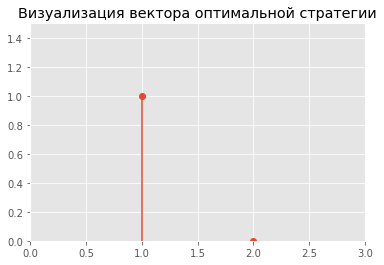

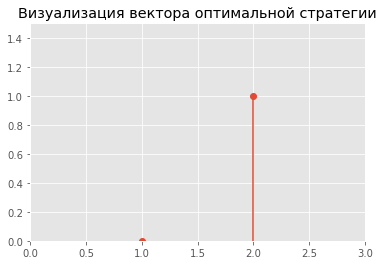

Game value is : 0.000
first optimal strategy (p) :  [ 1.00  0.00  ]
the second optimal strategy (q) :  [ 0.00  1.00  ]


In [21]:
main()

4.00  7.00  2.00  
7.00  3.00  2.00  
2.00  1.00  8.00  
матрица для симплекс метода:
0.00  -1.00  -1.00  -1.00  0.00  0.00  0.00  
1.00  4.00  7.00  2.00  1.00  0.00  0.00  
1.00  7.00  3.00  2.00  0.00  1.00  0.00  
1.00  2.00  1.00  8.00  0.00  0.00  1.00  
преобразованная матрица  1
0.14  0.00  -0.57  -0.71  0.00  0.14  0.00  
0.43  0.00  5.29  0.86  1.00  -0.57  0.00  
0.14  1.00  0.43  0.29  0.00  0.14  0.00  
0.71  0.00  0.14  7.43  0.00  -0.29  1.00  
преобразованная матрица  2
0.21  0.00  -0.56  0.00  0.00  0.12  0.10  
0.35  0.00  5.27  0.00  1.00  -0.54  -0.12  
0.12  1.00  0.42  0.00  0.00  0.15  -0.04  
0.10  0.00  0.02  1.00  0.00  -0.04  0.13  
преобразованная матрица  3
0.25  0.00  0.00  0.00  0.11  0.06  0.08  
0.07  0.00  1.00  0.00  0.19  -0.10  -0.02  
0.09  1.00  0.00  0.00  -0.08  0.20  -0.03  
0.09  0.00  0.00  1.00  -0.00  -0.04  0.14  


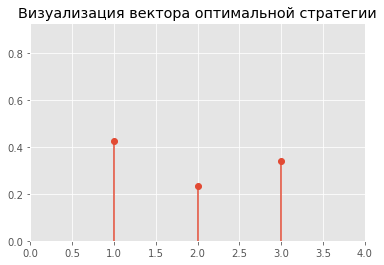

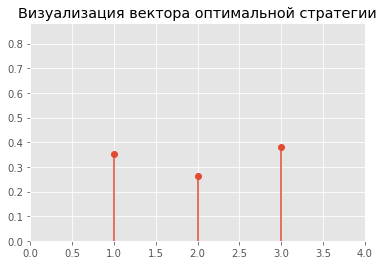

Game value is : 4.029
first optimal strategy (p) :  [ 0.43  0.24  0.34  ]
the second optimal strategy (q) :  [ 0.35  0.26  0.38  ]


In [22]:
a = np.array([[4,7,2],[7,3,2],[2,1,8]])
print_float_mat (a)
main (a)

2.00  3.00  
4.00  2.00  
1.00  6.00  
матрица для симплекс метода:
0.00  -1.00  -1.00  0.00  0.00  0.00  
1.00  2.00  3.00  1.00  0.00  0.00  
1.00  4.00  2.00  0.00  1.00  0.00  
1.00  1.00  6.00  0.00  0.00  1.00  
преобразованная матрица  1
0.25  0.00  -0.50  0.00  0.25  0.00  
0.50  0.00  2.00  1.00  -0.50  0.00  
0.25  1.00  0.50  0.00  0.25  0.00  
0.75  0.00  5.50  0.00  -0.25  1.00  
преобразованная матрица  2
0.32  0.00  0.00  0.00  0.23  0.09  
0.23  0.00  0.00  1.00  -0.41  -0.36  
0.18  1.00  0.00  0.00  0.27  -0.09  
0.14  0.00  1.00  0.00  -0.05  0.18  


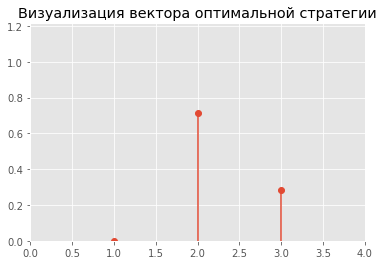

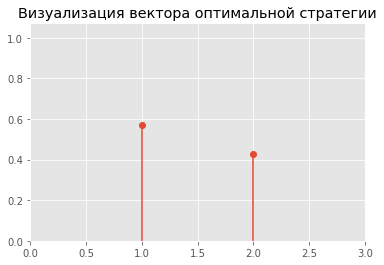

Game value is : 3.143
first optimal strategy (p) :  [ 0.00  0.71  0.29  ]
the second optimal strategy (q) :  [ 0.57  0.43  ]


In [23]:
a = np.array([[2,3],[4,2],[1,6]])
print_float_mat (a)
main (a)

4.00  0.00  6.00  2.00  2.00  1.00  
3.00  8.00  4.00  10.00  4.00  4.00  
1.00  2.00  6.00  5.00  0.00  0.00  
6.00  6.00  4.00  4.00  10.00  3.00  
10.00  4.00  6.00  4.00  0.00  9.00  
10.00  7.00  0.00  7.00  9.00  8.00  
матрица для симплекс метода:
0.00  -1.00  -1.00  -1.00  -1.00  -1.00  -1.00  0.00  0.00  0.00  0.00  0.00  0.00  
1.00  5.00  1.00  7.00  3.00  3.00  2.00  1.00  0.00  0.00  0.00  0.00  0.00  
1.00  4.00  9.00  5.00  11.00  5.00  5.00  0.00  1.00  0.00  0.00  0.00  0.00  
1.00  2.00  3.00  7.00  6.00  1.00  1.00  0.00  0.00  1.00  0.00  0.00  0.00  
1.00  7.00  7.00  5.00  5.00  11.00  4.00  0.00  0.00  0.00  1.00  0.00  0.00  
1.00  11.00  5.00  7.00  5.00  1.00  10.00  0.00  0.00  0.00  0.00  1.00  0.00  
1.00  11.00  8.00  1.00  8.00  10.00  9.00  0.00  0.00  0.00  0.00  0.00  1.00  
преобразованная матрица  1
0.09  0.00  -0.55  -0.36  -0.55  -0.91  -0.09  0.00  0.00  0.00  0.00  0.09  0.00  
0.55  0.00  -1.27  3.82  0.73  2.55  -2.55  1.00  0.00  0.00  0.00  -

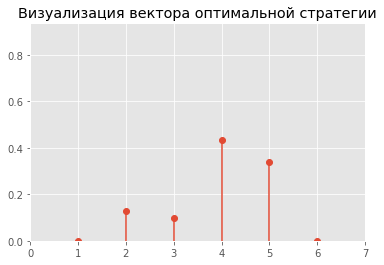

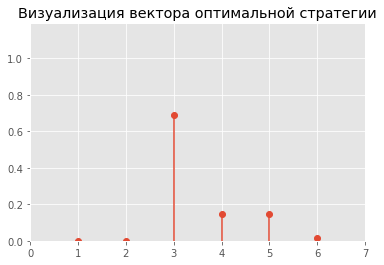

Game value is : 4.871
first optimal strategy (p) :  [ 0.00  0.13  0.10  0.44  0.34  0.00  ]
the second optimal strategy (q) :  [ 0.00  0.00  0.69  0.15  0.15  0.02  ]


In [24]:
a = np.array([[4,0,6,2,2,1],[3,8,4,10,4,4],[1,2,6,5,0,0],[6,6,4,4,10,3],[10,4,6,4,0,9],[10,7,0,7,9,8]])
print_float_mat (a)
main (a)

0.00  2.00  7.00  
12.00  11.00  1.00  
матрица для симплекс метода:
0.00  -1.00  -1.00  -1.00  0.00  0.00  
1.00  1.00  3.00  8.00  1.00  0.00  
1.00  13.00  12.00  2.00  0.00  1.00  
преобразованная матрица  1
0.08  0.00  -0.08  -0.85  0.00  0.08  
0.92  0.00  2.08  7.85  1.00  -0.08  
0.08  1.00  0.92  0.15  0.00  0.08  
преобразованная матрица  2
0.18  0.00  0.15  0.00  0.11  0.07  
0.12  0.00  0.26  1.00  0.13  -0.01  
0.06  1.00  0.88  0.00  -0.02  0.08  


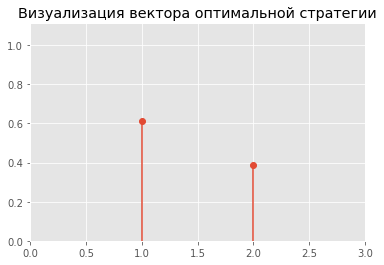

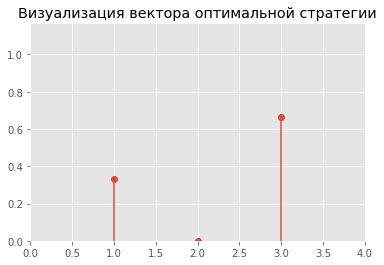

Game value is : 4.667
first optimal strategy (p) :  [ 0.61  0.39  ]
the second optimal strategy (q) :  [ 0.33  0.00  0.67  ]


In [25]:
a = a = np.array([[0,2,7],[12,11,1]])
print_float_mat (a)
main (a)

1.00  4.00  6.00  
7.00  2.00  1.00  
5.00  3.00  2.00  
матрица для симплекс метода:
0.00  -1.00  -1.00  -1.00  0.00  0.00  0.00  
1.00  1.00  4.00  6.00  1.00  0.00  0.00  
1.00  7.00  2.00  1.00  0.00  1.00  0.00  
1.00  5.00  3.00  2.00  0.00  0.00  1.00  
преобразованная матрица  1
0.14  0.00  -0.71  -0.86  0.00  0.14  0.00  
0.86  0.00  3.71  5.86  1.00  -0.14  0.00  
0.14  1.00  0.29  0.14  0.00  0.14  0.00  
0.29  0.00  1.57  1.29  0.00  -0.71  1.00  
преобразованная матрица  2
0.27  0.00  -0.17  0.00  0.15  0.12  0.00  
0.15  0.00  0.63  1.00  0.17  -0.02  0.00  
0.12  1.00  0.20  0.00  -0.02  0.15  0.00  
0.10  0.00  0.76  0.00  -0.22  -0.68  1.00  
преобразованная матрица  3
0.29  0.00  0.00  0.00  0.10  -0.03  0.23  
0.06  0.00  0.00  1.00  0.35  0.55  -0.84  
0.10  1.00  0.00  0.00  0.03  0.32  -0.26  
0.13  0.00  1.00  0.00  -0.29  -0.90  1.32  
преобразованная матрица  4
0.29  0.00  0.00  0.06  0.12  0.00  0.18  
0.12  0.00  0.00  1.82  0.65  1.00  -1.53  
0.06  1.00  0.

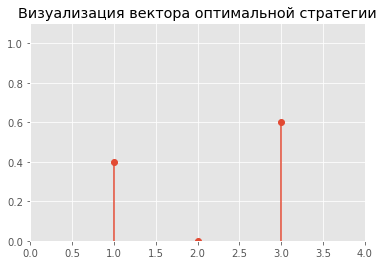

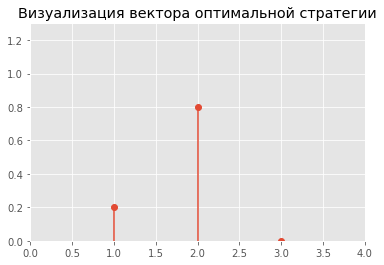

Game value is : 3.400
first optimal strategy (p) :  [ 0.40  0.00  0.60  ]
the second optimal strategy (q) :  [ 0.20  0.80  0.00  ]


In [26]:
a = np.array([[1, 4, 6],[7, 2, 1],[5, 3, 2]])
print_float_mat (a)
main (a)

1.00  6.00  8.00  3.00  
4.00  9.00  5.00  7.00  
3.00  2.00  7.00  6.00  


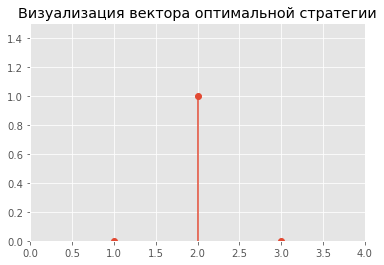

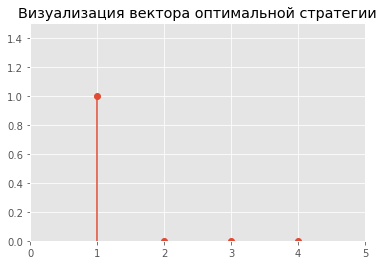

Game value is : 4.000
first optimal strategy (p) :  [ 0.00  1.00  0.00  ]
the second optimal strategy (q) :  [ 1.00  0.00  0.00  0.00  ]


In [27]:
a_mat = np.array([[1,6,8,3],[4,9,5,7],[3,2,7,6]])
print_float_mat (a_mat)
main (a_mat)

5.00  4.00  6.00  2.00  
1.00  2.00  0.00  1.00  
2.00  0.00  0.00  1.00  
3.00  0.00  1.00  6.00  
0.00  0.00  0.00  0.00  
матрица для симплекс метода:
0.00  -1.00  -1.00  -1.00  -1.00  0.00  0.00  0.00  0.00  0.00  
1.00  6.00  5.00  7.00  3.00  1.00  0.00  0.00  0.00  0.00  
1.00  2.00  3.00  1.00  2.00  0.00  1.00  0.00  0.00  0.00  
1.00  3.00  1.00  1.00  2.00  0.00  0.00  1.00  0.00  0.00  
1.00  4.00  1.00  2.00  7.00  0.00  0.00  0.00  1.00  0.00  
1.00  1.00  1.00  1.00  1.00  0.00  0.00  0.00  0.00  1.00  
преобразованная матрица  1
0.17  0.00  -0.17  0.17  -0.50  0.17  0.00  0.00  0.00  0.00  
0.17  1.00  0.83  1.17  0.50  0.17  0.00  0.00  0.00  0.00  
0.67  0.00  1.33  -1.33  1.00  -0.33  1.00  0.00  0.00  0.00  
0.50  0.00  -1.50  -2.50  0.50  -0.50  0.00  1.00  0.00  0.00  
0.33  0.00  -2.33  -2.67  5.00  -0.67  0.00  0.00  1.00  0.00  
0.83  0.00  0.17  -0.17  0.50  -0.17  0.00  0.00  0.00  1.00  
преобразованная матрица  2
0.20  0.00  -0.40  -0.10  0.00  0.10  0.00  

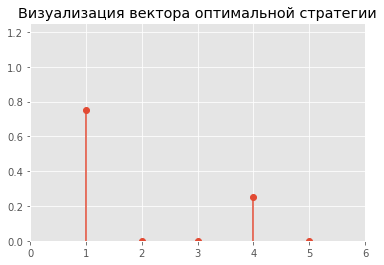

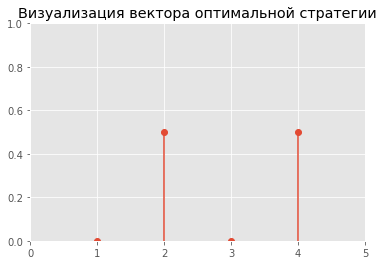

Game value is : 3.000
first optimal strategy (p) :  [ 0.75  0.00  0.00  0.25  0.00  ]
the second optimal strategy (q) :  [ 0.00  0.50  0.00  0.50  ]


In [28]:
a = np.array ([[5, 4, 6, 2],[1,2,0,1], [2,0,0,1], [3,0,1,6], [0,0,0,0]])
print_float_mat (a)
main (a)

9.00  16.00  9.00  -1.00  
-2.00  8.00  8.00  12.00  
9.00  16.00  -9.00  4.00  
матрица для симплекс метода:
0.00  -1.00  -1.00  -1.00  -1.00  0.00  0.00  0.00  
1.00  19.00  26.00  19.00  9.00  1.00  0.00  0.00  
1.00  8.00  18.00  18.00  22.00  0.00  1.00  0.00  
1.00  19.00  26.00  1.00  14.00  0.00  0.00  1.00  
преобразованная матрица  1
0.05  0.00  0.37  0.00  -0.53  0.05  0.00  0.00  
0.05  1.00  1.37  1.00  0.47  0.05  0.00  0.00  
0.58  0.00  7.05  10.00  18.21  -0.42  1.00  0.00  
0.00  0.00  0.00  -18.00  5.00  -1.00  0.00  1.00  
преобразованная матрица  2
0.07  0.00  0.57  0.29  0.00  0.04  0.03  0.00  
0.04  1.00  1.18  0.74  0.00  0.06  -0.03  0.00  
0.03  0.00  0.39  0.55  1.00  -0.02  0.05  0.00  
-0.16  0.00  -1.94  -20.75  0.00  -0.88  -0.27  1.00  


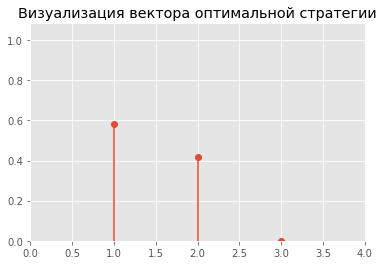

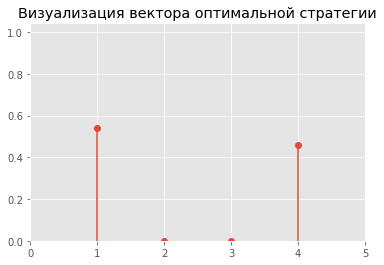

Game value is : 4.417
first optimal strategy (p) :  [ 0.58  0.42  0.00  ]
the second optimal strategy (q) :  [ 0.54  0.00  0.00  0.46  ]


In [29]:
matrix = np.array([
    [9, 16, 9, -1],
    [-2, 8, 8, 12],
    [9, 16, -9, 4]])
print_float_mat (matrix)
main(matrix)

2
1
0
-10


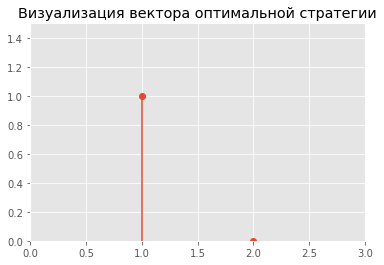

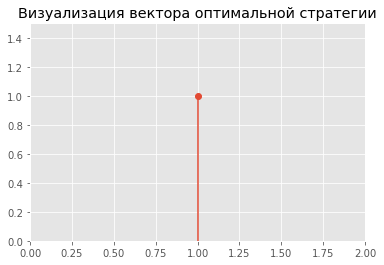

Game value is : 0.000
first optimal strategy (p) :  [ 1.00  0.00  ]
the second optimal strategy (q) :  [ 1.00  ]


In [31]:
main()